In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/Twitter Sentiment Analysis

In [ ]:
# Import standard libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
#Import machine learning library
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Import libraries for text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pickle

In [ ]:
# Import libraries for deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
# Download NLTK data if necessary
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
df = pd.read_csv('Twitter Sentiment Analysis.csv')

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20068 entries, 0 to 20067
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         20067 non-null  object
 1   user_location     15860 non-null  object
 2   user_description  18685 non-null  object
 3   user_created      20068 non-null  object
 4   user_followers    20068 non-null  int64 
 5   user_friends      20068 non-null  int64 
 6   user_favourites   20068 non-null  int64 
 7   user_verified     20068 non-null  bool  
 8   date              20068 non-null  object
 9   text              20068 non-null  object
 10  hashtags          15771 non-null  object
 11  source            20068 non-null  object
 12  is_retweet        20068 non-null  bool  
 13  Sentiment         20068 non-null  object
dtypes: bool(2), int64(3), object(9)
memory usage: 1.9+ MB
None


In [ ]:
print(df.head())

        user_name            user_location  \
0      Mari Smith    San Diego, California   
1      Mari Smith    San Diego, California   
2     Varun Tyagi               Goa, India   
3    Casey Conway  Sydney, New South Wales   
4  Charlotte Paul               Darlington   

                                    user_description         user_created  \
0  Premier Facebook Marketing Expert | Social Med...  2007-09-11 22:22:51   
1  Premier Facebook Marketing Expert | Social Med...  2007-09-11 22:22:51   
2  Indian | Tech Solution Artist & Hospitality Ex...  2009-09-06 10:36:01   
3  Head of Diversity & Inclusion @RugbyAU | It's ...  2012-12-28 21:45:06   
4                          Instagram Charlottejyates  2012-05-28 20:43:08   

   user_followers  user_friends  user_favourites  user_verified  \
0          579942        288625            11610          False   
1          579942        288625            11610          False   
2             257           204              475          F

Exploratory Data Analysis(EDA)

<ipython-input-11-11d2d0aab246>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment', palette='viridis')


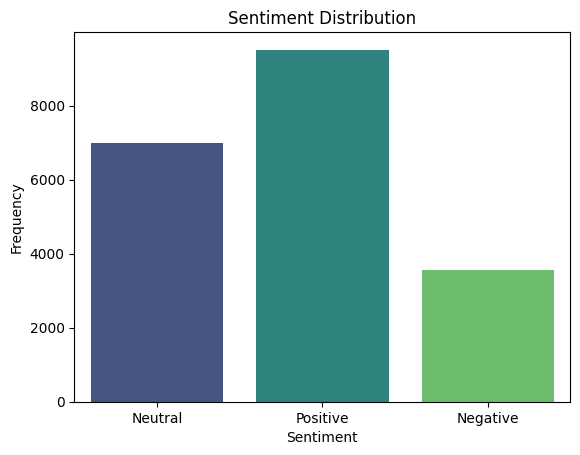

In [ ]:
sns.countplot(data=df, x='Sentiment', palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Add a column for tweet length
df['text_length'] = df['text'].apply(len)

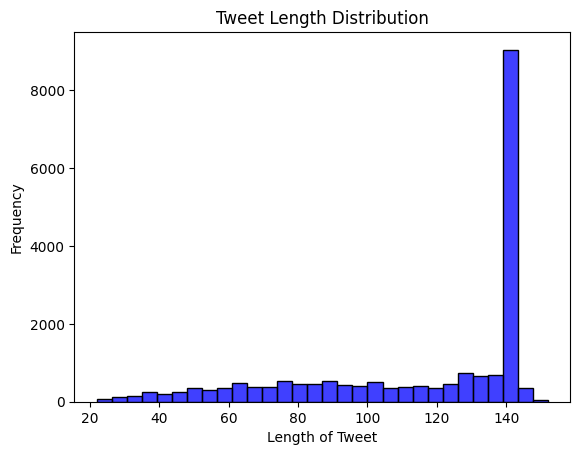

In [ ]:
# Visualize tweet length distribution
sns.histplot(df['text_length'], bins=30, color='blue')
plt.title('Tweet Length Distribution')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

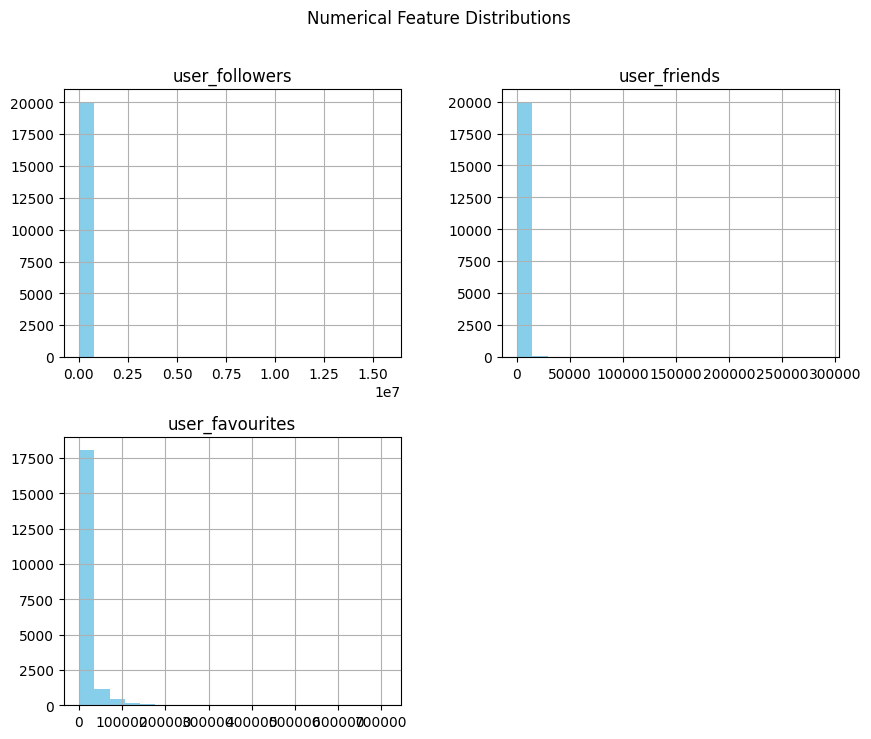

In [ ]:
# Plot histograms for numerical features
numerical_features = ['user_followers', 'user_friends', 'user_favourites']
df[numerical_features].hist(bins=20, figsize=(10, 8), color='skyblue')
plt.suptitle('Numerical Feature Distributions')
plt.show()

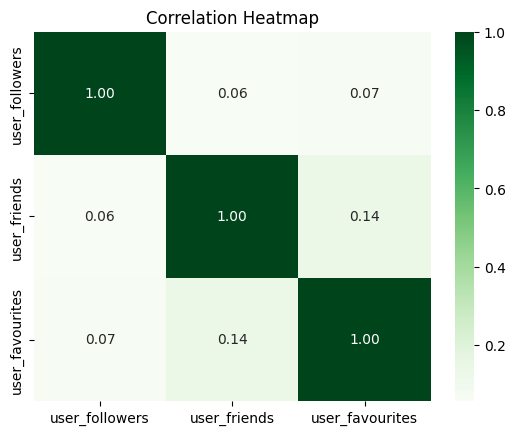

In [ ]:
# Correlation heatmap for numerical features
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

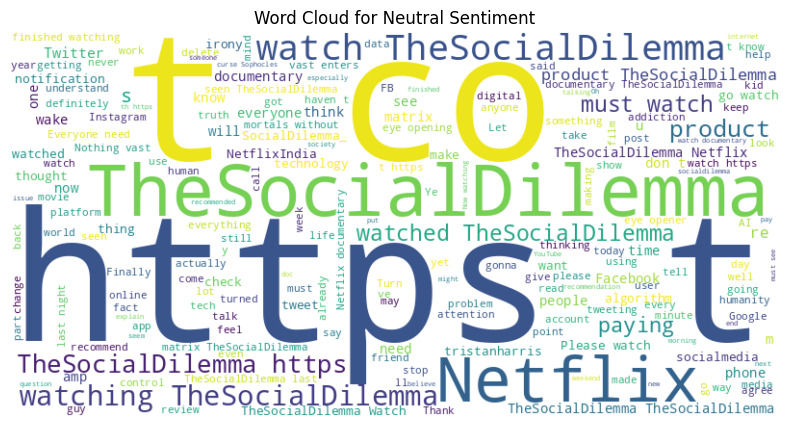

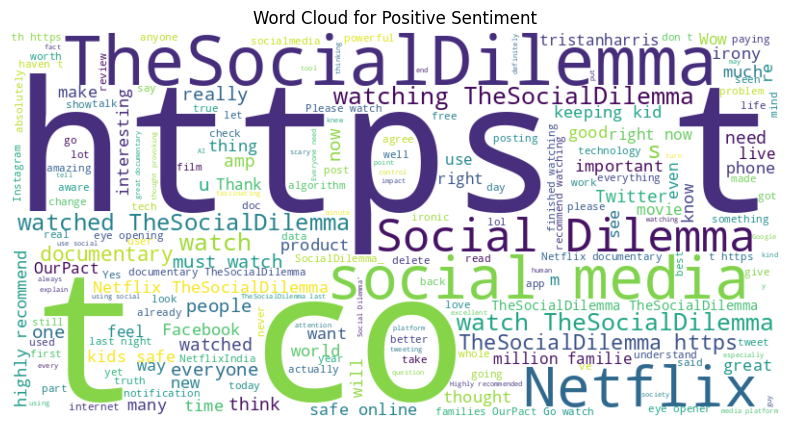

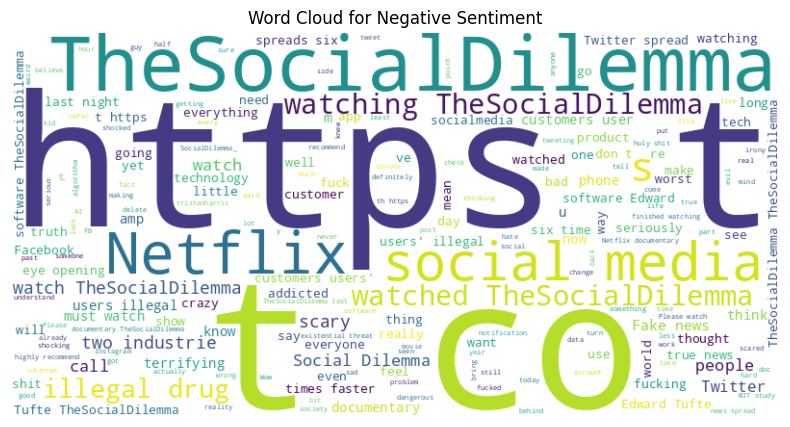

In [ ]:
# Word Cloud for Sentiment Categories
from wordcloud import WordCloud
for sentiment in df['Sentiment'].unique():
    text = " ".join(df[df['Sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()

Text Preprocessing

In [ ]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text)  # Remove URLs, mentions, hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize
    return ' '.join(tokens)

In [ ]:
# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

 Normalize Numerical Features

In [ ]:
scaler = MinMaxScaler()
df[['user_followers', 'user_friends']] = scaler.fit_transform(df[['user_followers', 'user_friends']])

Convert Text to TF-IDF Features

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
text_features = tfidf.fit_transform(df['cleaned_text'])

In [ ]:
# Assuming df['Sentiment'] contains strings like 'Neutral', 'Positive', 'Negative'
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to your sentiment labels
label_encoder.fit(df['Sentiment'])

# Transform the 'Sentiment' column to numerical labels
df['Sentiment_encoded'] = label_encoder.transform(df['Sentiment'])

# Assuming 'text_features' is your TF-IDF matrix and 'df' contains the scaled numerical features
X = pd.concat([pd.DataFrame(text_features.toarray()), df[['user_followers', 'user_friends']]], axis=1)

# Now use the encoded labels for one-hot encoding
y = to_categorical(df['Sentiment_encoded'])

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#Handle Class Imbalance
class_weights = {i: len(y_train) / sum(np.argmax(y_train, axis=1) == i) for i in range(y.shape[1])}

Define the Model

In [ ]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the Model

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

 Train the Model with Early Stopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.5563 - loss: 2.6159 - val_accuracy: 0.8204 - val_loss: 0.4933
Epoch 2/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.8833 - loss: 1.0378 - val_accuracy: 0.8361 - val_loss: 0.4541
Epoch 3/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9378 - loss: 0.5795 - val_accuracy: 0.8418 - val_loss: 0.4950
Epoch 4/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9638 - loss: 0.3591 - val_accuracy: 0.8266 - val_loss: 0.6084
Epoch 5/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9788 - loss: 0.2219 - val_accuracy: 0.8336 - val_loss: 0.6966


Evaluate the Model

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8362 - loss: 0.4431
Test Accuracy: 83.61%


In [ ]:

# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_test_classes, y_pred))

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       715
           1       0.84      0.89      0.86      1396
           2       0.90      0.84      0.87      1903

    accuracy                           0.84      4014
   macro avg       0.81      0.82      0.81      4014
weighted avg       0.84      0.84      0.84      4014



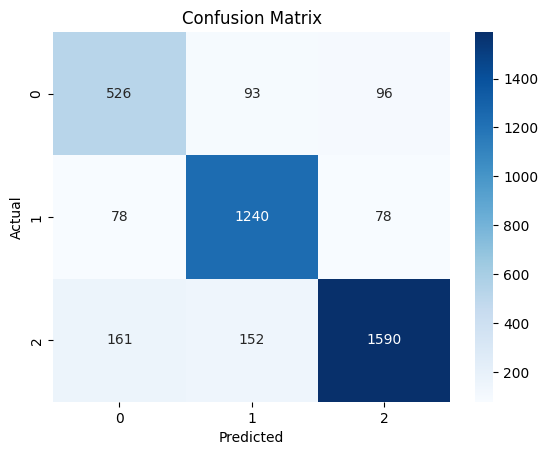

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Visualize Training Performance

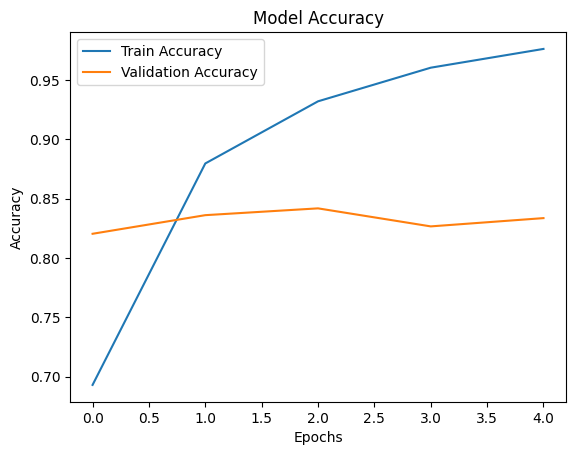

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

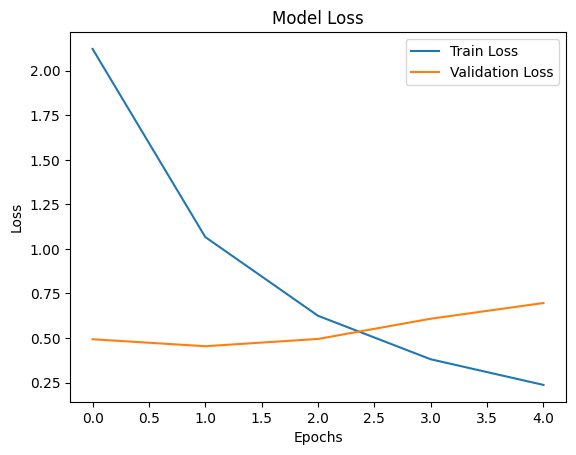

In [ ]:
# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

Save the Model and TF-IDF Vectorizer



In [ ]:
model.save('sentiment_ann_model.h5')
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)